# Getting Started With Robot Inverse Kinematics (IK)

Welcome to the first guide in the series of getting started with Dr.QP robot Inverse Kinematics (IK).
In this guide, we will cover the basics of IK and how to use it to control a robot.

## What is Inverse Kinematics?
Inverse Kinematics (IK) is a technique used in robotics to determine the joint angles required to achieve a desired end-effector position. It is the process of solving the inverse problem of forward kinematics, which calculates the end-effector position given the joint angles.

## Why is Inverse Kinematics Important?
Inverse Kinematics is important because it allows robots to perform complex movements and tasks. By calculating the joint angles required to reach a specific position, robots can navigate their environment and interact with objects more effectively.

## How to Use Inverse Kinematics
To use Inverse Kinematics, you need to have a model of your robot's kinematics. This model includes the lengths of the robot's links and the joint angles. Once you have this model, you can use it to calculate the joint angles required to achieve a desired end-effector position.

## Setting up the Jupyter notebook

Before we start, lets configure matplotlib to display plots inline:

In [1]:
%matplotlib inline

As well as enable live python modules reloading, so you can change the code in sibling files and see the results immediately without restarting the kernel

In [2]:
# Enable python modules live reloading
%load_ext autoreload
%autoreload 2

## The robot model

For this tutorial we will use the simplest part of Dr.QP robot - a single leg.

It has a 3 degrees of freedom and consists of 3 links:
 - coxa (hip)
 - femur (thigh)
 - tibia (shin)
 
and 3 joints:
 - alpha (coxa joint, hip joint)
 - beta (femur joint, thigh joint)
 - gamma (tibia joint, shin joint)

Links have only single property - length. They are connected to each other with joints. Joints have only single property - angle.

The diagrams below will make it much more clear, I promise, so just keep reading.

The values below are the default parameters for the simulated leg used in this tutorial.

In [3]:
coxa_length = 3
femur_length = 4
tibia_length = 7

alpha = 0 # controls coxa angle, 0 is straight
beta = 0 # controls femur angle, 0 is straight
gamma = 0 # controls tibia angle, 0 is straight

## Forward kinematics

Before we dive into the details of how inverse kinematics works, let's first get familiar with forward kinematics. The forward kinematics of the robotic leg is the process of calculating the position of the foot based on the angles of the joints.

Coxa, femur and tibia are represented with vector that is rotated at its base. Each next link starts at the ened of the previous link.
The starting point is (0, 0).

In [4]:
from point import Point


def forward_kinematics(coxa_length, femur_length, tibia_length, alpha_rad, beta_rad, gamma_rad, start = Point(0, 0)):
    start.label = f'{alpha_rad=}rads'
    coxa = start + Point(coxa_length, 0, f'{beta_rad=}rads').rotate(alpha_rad)
    femur = coxa + Point(femur_length, 0, f'{gamma_rad=}rads').rotate(beta_rad)
    tibia = femur + Point(tibia_length, 0, 'Foot').rotate(gamma_rad)

    return [start, coxa, femur, tibia]


Radians is a natural way to represent angles in most of the math related to robotics, however most people are more used to degrees. Thus I will be using degrees in this notebook.

In [5]:
import numpy as np

def forward_kinematics_angles(coxa_length, femur_length, tibia_length, alpha, beta, gamma, start = Point(0, 0)):
    alpha_rad = np.radians(alpha)
    beta_rad = np.radians(beta) + alpha_rad
    gamma_rad = np.radians(gamma) + beta_rad

    start, coxa, femur, tibia = forward_kinematics(coxa_length, femur_length, tibia_length, alpha_rad, beta_rad, gamma_rad, start=start)

    start.label = fr'$\alpha$={alpha}°'
    coxa.label = fr'$\beta$={beta}°'
    femur.label = fr'$\gamma$={gamma}°'
    return start, coxa, femur, tibia


First, lets see how our leg looks in the neutral position. It is a straight line going from start point at (0, 0) and ending with the `Foot`

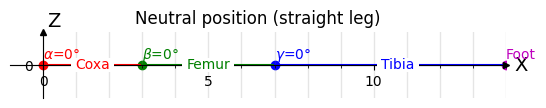

In [6]:
%matplotlib inline
from plotting import plot_leg_with_points

points = forward_kinematics_angles(coxa_length, femur_length, tibia_length, alpha, beta, gamma)

_ = plot_leg_with_points(points, 'Neutral position (straight leg)')

Now lets try changing some angles to see how it behaves. Feel free to experiment with different values.

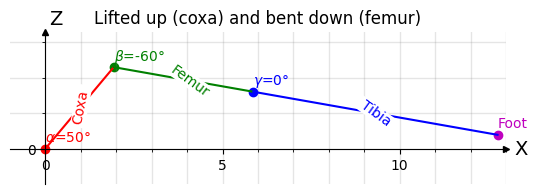

In [7]:
%matplotlib inline

points = forward_kinematics_angles(coxa_length, femur_length, tibia_length, 50, -60, 0)

_ = plot_leg_with_points(points, 'Lifted up (coxa) and bent down (femur)')


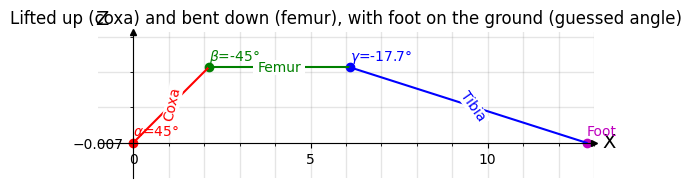

In [8]:
%matplotlib inline

points = forward_kinematics_angles(coxa_length, femur_length, tibia_length, 45, -45, -17.7)

_ = plot_leg_with_points(points, 'Lifted up (coxa) and bent down (femur), with foot on the ground (guessed angle)')

## Exercise 1. Forward kinematics. Find angles at which the leg is on the ground

Its time to have a little fun with our robot.

Using the sliders on the interactive diagram below try to find angles at which the foot is on the ground.

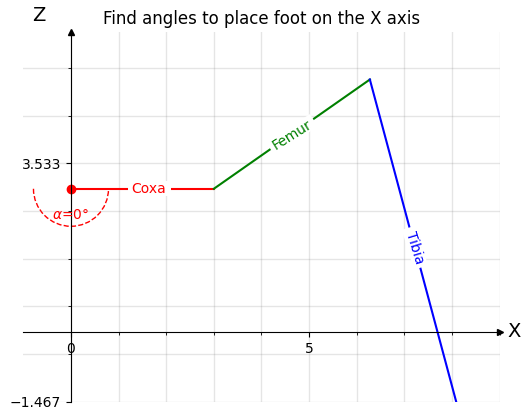

In [36]:

from plotting import plot_leg_update_lines
from ipywidgets import interact
import matplotlib


# To switch to interactive mode:
#  1. Set is_interactive to True
#  2. Restart kernel and run all the cells above
# DO NOT RUN THE CELLS BELOW, matplotlib's widget backend has to be the last magic executed to use interactive backend
is_interactive = False

matplotlib.use('widget' if is_interactive else 'inline')

start=Point(0, 3)
alpha=0
beta=35
gamma=-110
points = forward_kinematics_angles(coxa_length, femur_length, tibia_length, alpha, beta, gamma, start=start)
fig, _, lines, joints = plot_leg_with_points(points, 'Find angles to place foot on the X axis', no_joint_labels=is_interactive, no_link_labels=is_interactive)

def update(alpha=alpha, beta=beta, gamma=gamma):
    points = forward_kinematics_angles(coxa_length, femur_length, tibia_length, alpha, beta, gamma, start=start)
    plot_leg_update_lines(points, lines, joints)
    fig.canvas.draw_idle()

if is_interactive:
    interact(update,
      alpha=(-180, 180, 0.1),
      beta=(-180, 180, 0.1),
      gamma=(-180, 180, 0.1))

In [10]:
if is_interactive:
    raise Exception("Stopping here to avoid breaking interactive mode. Set is_interactive to False in the cell above and execute it and all below.")

That was a fun little exercise, but it takes some effort to find just the right angle, and you might have noticed that there are more than one solution to it. 

The problem of having more than one solution is known as over-actuation. It happens for our robotic leg because there are 3 joints in the same plain, giving leg ability of reaching desired goal using various combinations of joint angles. Essentially if links create a polygon with more than 3 sides (more than triangle), then there are multiple solutions.

However, it is not an issue in the real Dr.QP hexapod robot as coxa joint is in the different plain in 3D space. Therefore we are not going to expand on this topic further right now and will keep coxa joint angle (alpha) fixed at 0 degree. This will prevent over-actuation and simplify the problem.

There are various ways to solve inverse kinematics problem. We are going to use the most basic one, which is based on trigonometry, since Dr.QP legs are not over-actuated.

## Solving inverse kinematics using trigonometry



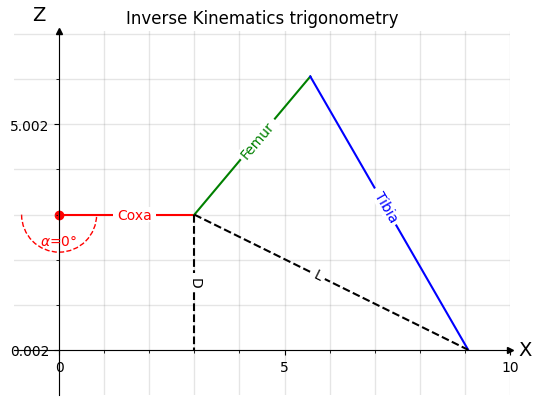

In [35]:
%matplotlib inline

from inline_labels import add_inline_labels

start=Point(0, 3)
points = forward_kinematics_angles(coxa_length, femur_length, tibia_length, 0, 50, -110, start=start)

fig, ax, _, _ = plot_leg_with_points(points, 'Inverse Kinematics trigonometry', no_link_labels=True)

coxa_joint, femur_joint, tibia_joint, foot = points
ax.plot([femur_joint.x, foot.x], [femur_joint.y, foot.y], 'k--', label='L')

ax.plot([femur_joint.x, femur_joint.x], [femur_joint.y, 0], 'k--', label='D')

add_inline_labels(ax, with_overall_progress=False, fontsize='medium')

pass